# Introduction  (Offline version)

In this notebook, we will predict health insurance cost that someone should pay annually by the given features.
For the complete introduction, see the slides.

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [9]:
### this library is for callback functions
### you have to download this tensorflow_docs through github
### https://github.com/tensorflow/docs
### import from the directory where you saved tensorflow_docs

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# Medical Cost Personal Datasets

## Retrieve the dataset

Manage the dataset into pandas' DataFrame.

In [10]:
dataset = pd.read_csv("datasets/insurance.csv", header=0)
dataset

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Clean the data

Checking the dataset whether its contains some undefined measurement or not.

In [11]:
dataset.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Convert categorical columns into numeric with the following convention:

* `sex`: male = 1, female = 2,

* `smoker`: yes = 1, no = 0,

* `region`: northeast = $\displaystyle\frac{\pi}{4}$, northwest = $\displaystyle\frac{3\pi}{4}$, southwest = $\displaystyle\frac{5\pi}{4}$, southeast = $\displaystyle\frac{7\pi}{4}$. We use the representation of direction by their angle on unit circle. If we compute the method `.mean`, it will make a sense (where is the region whose citizens are the most recorded).

In [12]:
dataset.loc[dataset['sex'] == 'male', 'sex'] = 1
dataset.loc[dataset['sex'] == 'female', 'sex'] = 2

dataset.loc[dataset['smoker'] == 'yes', 'smoker'] = 1
dataset.loc[dataset['smoker'] == 'no', 'smoker'] = 0

dataset.loc[dataset['region'] == 'northeast', 'region'] = np.pi/4
dataset.loc[dataset['region'] == 'northwest', 'region'] = 3*np.pi/4
dataset.loc[dataset['region'] == 'southwest', 'region'] = 5*np.pi/4
dataset.loc[dataset['region'] == 'southeast', 'region'] = 7*np.pi/4

dataset['region'] = pd.to_numeric(dataset['region'])

dataset

,age,sex,bmi,children,smoker,region,charges
0,19,2,27.900,0,1,3.926991,16884.92400
1,18,1,33.770,1,0,5.497787,1725.55230
2,28,1,33.000,3,0,5.497787,4449.46200
3,33,1,22.705,0,0,2.356194,21984.47061
4,32,1,28.880,0,0,2.356194,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,2.356194,10600.54830
1334,18,2,31.920,0,0,0.785398,2205.98080
1335,18,2,36.850,0,0,5.497787,1629.83350
1336,21,2,25.800,0,0,3.926991,2007.94500


In [13]:
target = dataset['charges']
features = dataset.drop(columns='charges')

features.head()

,age,sex,bmi,children,smoker,region
0,19,2,27.900,0,1,3.926991
1,18,1,33.770,1,0,5.497787
2,28,1,33.000,3,0,5.497787
3,33,1,22.705,0,0,2.356194
4,32,1,28.880,0,0,2.356194


## Split the data into a training set and a test set.

In [14]:
class SortedStratifiedKFold:
    
    """
    This is a class for split data into a few groups, which is each group has same distribution.
    Usually this method regarded as Stratified K Fold Cross Validation. But I create another one
    for continuous data at target's dataset with Sorted Stratified K Fold method. This method inspired
    by article (https://scottclowe.com/2016-03-19-stratified-regression-partitions/).
    
    This method is useful to make sure validation and test performance gives depicts 
    the expected performance of the model with less bias and variance.
    """
    
    def __init__(self, n_splits):
        self._n_splits = n_splits
    
    def split(self, X, y):
        x = X.copy()
        
        # sorted target values
        self._sorted_idx = y.sort_values().index
        
        self._groups = [list() for _ in range(self._n_splits)]
        it = int(np.ceil(x.shape[0] / self._n_splits))
        
        for i in range(it):
            c = i * self._n_splits
            
            if (len(y) % self._n_splits != 0) and i==(it-1):
                rand_idx = np.random.permutation(range(len(y) % self._n_splits)) + c
                
                for j in range(len(rand_idx)):
                    self._groups[j].append(self._sorted_idx[rand_idx[j]])
                
            else:
                rand_idx = np.random.permutation(range(self._n_splits)) + c
                
                for j in range(self._n_splits):
                    self._groups[j].append(self._sorted_idx[rand_idx[j]])
                    
                  
        return [(x.iloc[list(set(y.index) - set(idx))], y.iloc[list(set(y.index) - set(idx))], 
                                 x.iloc[idx], y.iloc[idx]) for idx in self._groups]

We divided the dataset into 5 groups to get 20% of data for test set

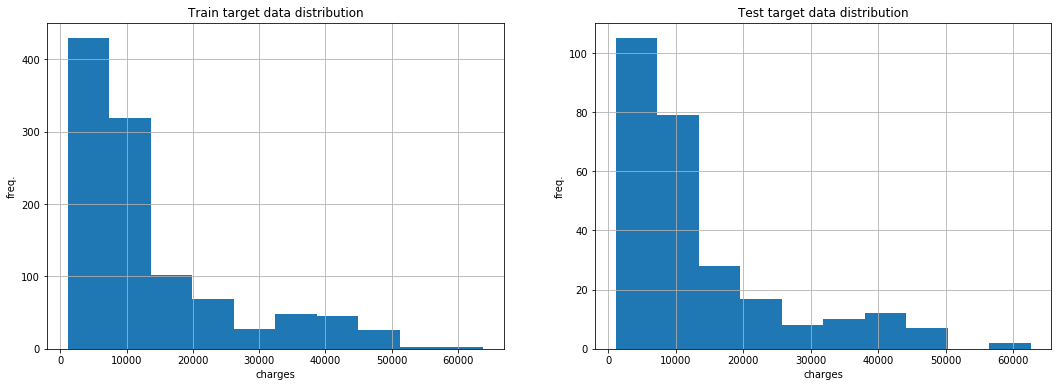

In [15]:
n_splits = 5

ssfk = SortedStratifiedKFold(n_splits=n_splits)

train_test_split = ssfk.split(features, target)
train_features, train_target, test_features, test_target = train_test_split[0]

plt.figure(figsize=(18,6))
plt.subplot(121)
train_target.hist().set_title('Train target data distribution')
plt.xlabel('charges')
plt.ylabel('freq.')

plt.subplot(122)
test_target.hist().set_title('Test target data distribution')
plt.xlabel('charges')
plt.ylabel('freq.');

In [16]:
test_target

22       1137.01100
442      1149.39590
487      1253.93600
385      1261.85900
77       1532.46970
           ...     
94      47291.05500
288     47896.79135
1062    48970.24760
577     58571.07448
1300    62592.87309
Name: charges, Length: 268, dtype: float64

## Inspect the data

We look at the joint distribution of a few pairs of columns from the training set. The diagonal elements represent kernel density estimation (kde) for univariate variables for given columns. We include all the columns to inspect which variable has a correlation to another variable

In [17]:
train_dataset = train_features.copy()
train_dataset[train_target.name] = train_target.copy()
train_dataset.head()

,age,sex,bmi,children,smoker,region,charges
1,18,1,33.770,1,0,5.497787,1725.55230
3,33,1,22.705,0,0,2.356194,21984.47061
4,32,1,28.880,0,0,2.356194,3866.85520
5,31,2,25.740,0,0,5.497787,3756.62160
6,46,2,33.440,1,0,5.497787,8240.58960


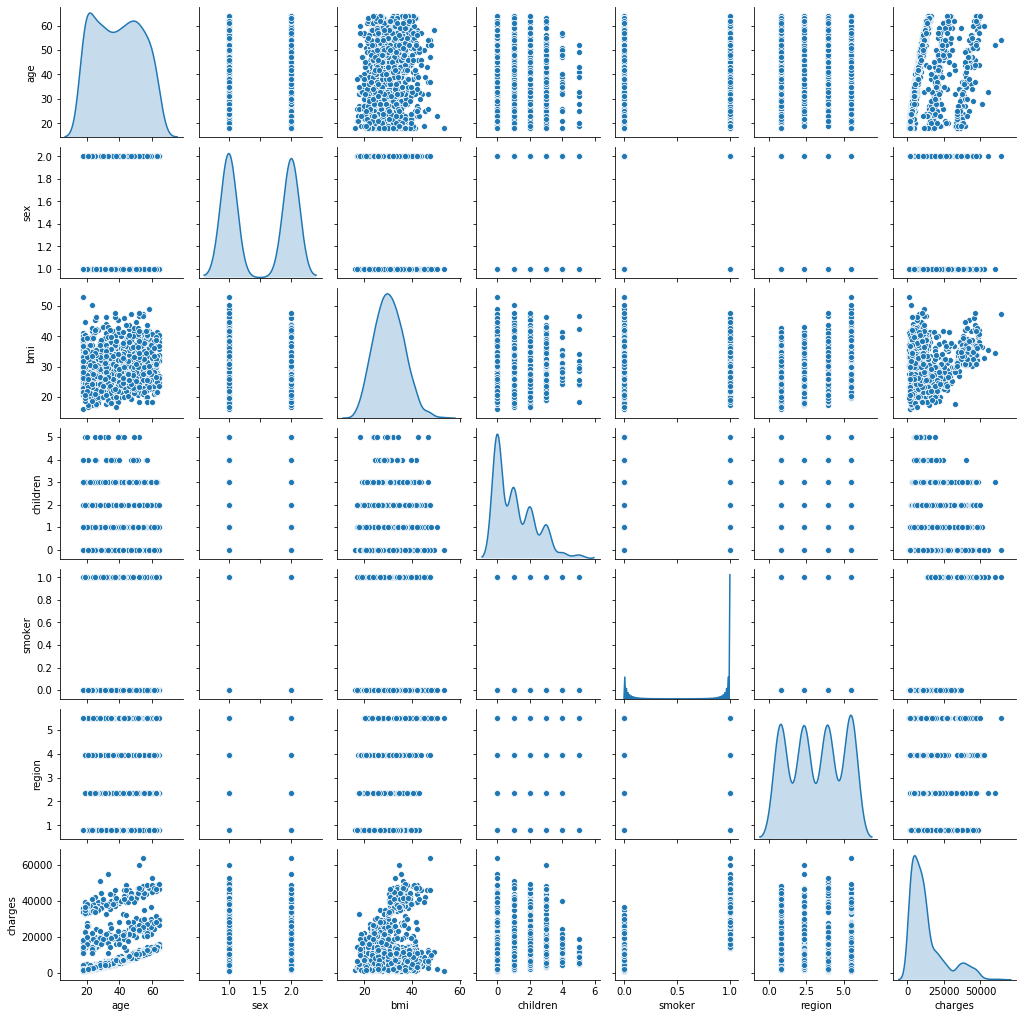

In [18]:
sns.pairplot(train_dataset[['age', 'sex', 'bmi', 'children', 'smoker', 
                            'region', 'charges']], 
             diag_kind='kde', height=2);

If we look at the above table, we can easily notice how categorical and numerical data behave. For continous ones, they are correlated like many clusters, but for the discrete ones, they grouped and distributed by their categories.

We also inspect at their statistical description:

In [85]:
train_stats = train_dataset.describe()
train_stats.pop('charges')

# for pretty output
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.211215,14.070392,18.000000,26.000000,39.000000,51.000000,64.000000
sex,1070.0,1.502804,0.500226,1.000000,1.000000,2.000000,2.000000,2.000000
bmi,1070.0,30.739514,6.102563,16.815000,26.336250,30.352500,34.770000,52.580000
children,1070.0,1.093458,1.194254,0.000000,0.000000,1.000000,2.000000,5.000000
smoker,1070.0,0.201869,0.401583,0.000000,0.000000,0.000000,0.000000,1.000000
region,1070.0,3.225271,1.762903,0.785398,2.356194,3.926991,5.497787,5.497787


## Normalize the data

In [0]:
def normalize(x_val):
    return (x_val - train_stats['mean']) / train_stats['std']

normed_train_features = normalize(train_features)
normed_test_features = normalize(test_features)

In [87]:
normed_train_features.head()

,age,sex,bmi,children,smoker,region
0,-1.436436,0.993943,-0.465299,-0.915599,1.987463,0.398048
1,-1.507507,-1.005153,0.496592,-0.078256,-0.502684,1.289077
2,-0.796795,-1.005153,0.370416,1.596429,-0.502684,1.289077
3,-0.441439,-1.005153,-1.316580,-0.915599,-0.502684,-0.492980
4,-0.512510,-1.005153,-0.304710,-0.915599,-0.502684,-0.492980


# Modelling Data

## Construct the model
In this model we use the multilayer perceptron model with two densely connected hidden layars (`layer.Dense(64)`), and an output layer that returns a single continuous value (`layer.Dense(1)`).


In [0]:
def multilayer_perceptron(num_features, learning_rate, optimizers, regularizer_rate=0, dropout_rate=0):
    
    num_perceptron=64
    
    # set optimizers
    if optimizers=='adam':
        opt = tf.keras.optimizers.Adam(lr=learning_rate)
    elif optimizers=='rmsprop':
        opt = tf.keras.optimizers.RMSprop(lr=learning_rate)
    elif optimizers=='sgd':
        opt = tf.keras.optimizers.SGD(lr=learning_rate)
    
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=num_perceptron, activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(regularizer_rate), 
                                    input_shape=(num_features,)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units=num_perceptron, 
                                    kernel_regularizer=tf.keras.regularizers.l2(regularizer_rate), 
                                    activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units=1, activation='relu'))
    
        
    model.compile(optimizer=opt, loss='mae', 
                  metrics=['mae', 'mse'])
    
    return model
    
    
def train_model(model, features, target, epoch):
    
    history = model.fit(x=features, y=target, epochs=epoch, verbose=0)
    
    hist = pd.DataFrame(history.history)
    
    return model, hist

## Hypertuning Parameter

### Optimizer with different learning rate

In [0]:
normed_train_features = normed_train_features.reset_index()[features.columns]
train_target = train_target.reset_index()['charges']

n_splits_target = 4

ssfk = SortedStratifiedKFold(n_splits=n_splits_target)

# train_val_split contains four elements of tuples 
# (train_feature, train_target, test_feature, test_target) because we use 
# n_splits_target is 80% of the remaining data

train_val_split = ssfk.split(normed_train_features, train_target)

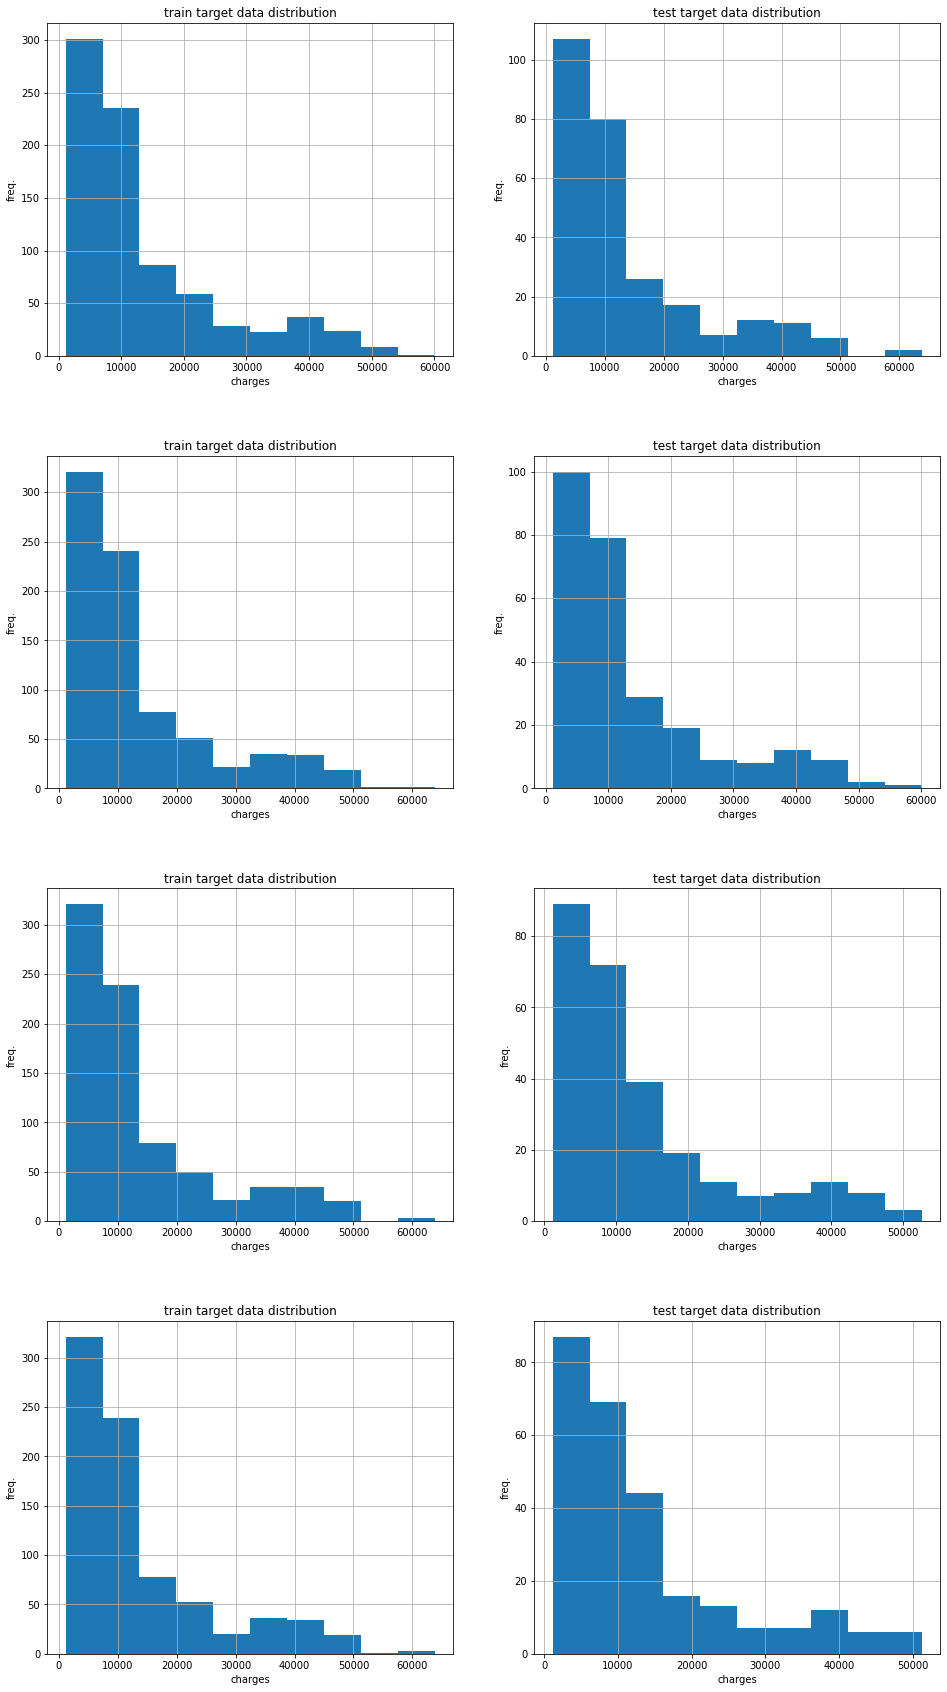

In [90]:
plt.figure(figsize=(16, 30))
for i, (train_feature, train_target, test_feature, test_target) in enumerate(train_val_split):
    plt.subplot(4, 2, 2*i + 1)
    train_target.hist().set_title("train target data distribution")
    plt.xlabel('charges')
    plt.ylabel('freq.')
    
    plt.subplot(4, 2, 2*(i+1))
    test_target.hist().set_title("test target data distribution")
    plt.xlabel('charges')
    plt.ylabel('freq.')

plt.subplots_adjust(hspace=0.3)

In [91]:
train_target.shape

(803,)

In [92]:
learning_rates_list = [.001, .0025, .005, .0075, .01, .025, .05, .075, .1]
result_report = pd.DataFrame({'Learning Rate': learning_rates_list})
result_report

,Learning Rate
0,0.0010
1,0.0025
2,0.0050
3,0.0075
4,0.0100
5,0.0250
6,0.0500
7,0.0750
8,0.1000


In [0]:
start_compute = time.time()

N_epoch = 4000
#N_epoch = 40

for i, (train_features, train_target, 
        validation_features, validation_target) in enumerate(train_val_split):

    print('n_split_target:', i+1)

    adam_mae, rmsprop_mae, sgd_mae = [], [], []
    print('    Adam training process...')
    for lr in learning_rates_list:
        mlp = multilayer_perceptron(train_features.shape[1], lr, 'adam')
        model, history = train_model(mlp, train_features, train_target, N_epoch)
        loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=1)
        adam_mae.append(mae)

    print('    RMSprop training process...')
    for lr in learning_rates_list:
        mlp = multilayer_perceptron(train_features.shape[1], lr, 'rmsprop')
        model, history = train_model(mlp, train_features, train_target, N_epoch)
        loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=1)
        rmsprop_mae.append(mae)

    print('    SGD training process...')
    for lr in learning_rates_list:
        mlp = multilayer_perceptron(train_features.shape[1], lr, 'sgd')
        model, history = train_model(mlp, train_features, train_target, N_epoch)
        loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=1)
        sgd_mae.append(mae)

    result_report['Adam-'+str(i+1)] = adam_mae
    result_report['RMSprop-'+str(i+1)] = rmsprop_mae
    result_report['SGD-'+str(i+1)] = sgd_mae

print("Approximation computational time: {:.2f}".format(time.time() - start_compute))

n_split_target: 1
    Adam training process...
9/9 [==============================] - 0s 2ms/step - loss: 2081.8174 - mae: 1887.0195 - mse: 28596516.0000
    RMSprop training process...
9/9 [==============================] - 0s 2ms/step - loss: 2222.7712 - mae: 2014.6176 - mse: 25306298.0000
    SGD training process...
9/9 [==============================] - 0s 1ms/step - loss: 11815.7080 - mae: 9462.3359 - mse: 222480672.0000
n_split_target: 2
    Adam training process...
9/9 [==============================] - 0s 2ms/step - loss: 2076.4397 - mae: 1966.5215 - mse: 27361188.0000
    RMSprop training process...
9/9 [==============================] - 0s 1ms/step - loss: 2039.3876 - mae: 1994.3394 - mse: 30402826.0000
    SGD training process...
9/9 [==============================] - 0s 1ms/step - loss: 11099.2451 - mae: 8873.9072 - mse: 196706688.0000
n_split_target: 3
    Adam training process...
9/9 [==============================] - 0s 1ms/step - loss: 1083.4078 - mae: 1085.2008 - mse: 

In [71]:
result_report     # mae each method

,Learning Rate,Adam-1,RMSprop-1,SGD-1,Adam-2,RMSprop-2,SGD-2,Adam-3,RMSprop-3,SGD-3,Adam-4,RMSprop-4,SGD-4,Adam-Avg,RMSprop-Avg,SGD-Avg
0,0.0010,1607.701172,1648.003906,1899.753784,1586.947144,1686.917480,1810.030518,1440.823853,1501.899414,1577.726440,1390.861206,1283.475952,1502.863525,4661.329132,2171.111572,2352.830109
1,0.0025,1497.789185,1579.930664,2187.274658,1512.037109,1544.597900,1809.601685,1344.374634,1364.682007,1661.121216,1311.232666,1339.669434,2035.583130,1520.976746,4559.203278,2511.407471
2,0.0050,1610.663086,1632.178589,2452.177490,1488.946777,1602.048340,3459.715088,1373.023682,1358.299927,3187.398926,1114.056152,1448.124878,2322.268799,1549.885132,1490.352661,2476.446289
3,0.0075,1608.656494,1713.847290,2720.301514,1910.180054,1563.657837,2356.049805,1309.004272,1492.756104,3074.177734,1285.317139,1355.200317,1905.876221,1650.958771,1627.048798,3928.875916
4,0.0100,1618.856934,2006.599365,3472.440186,1629.001953,1563.835083,3308.797119,1448.126831,1479.134888,2965.725098,1451.626099,1184.748047,2057.730469,4728.435272,1665.173828,3369.451965
5,0.0250,1752.066895,1840.804199,8942.929688,1706.751465,1739.104004,12689.749023,1484.651733,1446.613281,9955.073242,1235.133789,1403.670044,8469.422852,1615.700775,1762.159515,5124.537476
6,0.0500,1592.172974,1762.730713,12508.705078,1740.979980,1919.998169,12401.921875,1527.280762,13133.948242,8282.590820,1353.440918,1733.188110,11897.758789,1545.667603,1866.787140,11618.589478
7,0.0750,1777.396729,1930.127808,13326.888672,1706.980347,1876.344727,11733.224609,1415.462280,1957.803711,11316.223633,1295.134888,1731.730103,11361.523438,1578.993500,1892.599365,12590.173584
8,0.1000,1808.881104,1851.852173,11439.549805,1553.274902,1856.828369,11114.780273,1647.222778,1913.486938,13133.948242,1264.557251,1499.046875,13161.991211,1655.054718,1977.862488,13014.769287


In [72]:
Adam_RMSpropAvg_SGDAvg_Str = np.array([['Adam-{:d}'.format(i+1), 
                               'RMSprop-{:d}'.format(i+1),
                               'SGD-{:d}'.format(i+1)] for i in range(n_splits_target)], dtype=str)
Adam_RMSpropAvg_SGDAvg_Str

array([['Adam-1', 'RMSprop-1', 'SGD-1'],
       ['Adam-2', 'RMSprop-2', 'SGD-2'],
       ['Adam-3', 'RMSprop-3', 'SGD-3'],
       ['Adam-4', 'RMSprop-4', 'SGD-4']], dtype='<U9')

In [73]:
result_report['Adam-Avg'] = \
    sum(result_report[idx] 
        for idx in Adam_RMSpropAvg_SGDAvg_Str[:,0]) / n_splits_target

result_report['RMSprop-Avg'] = \
    sum(result_report[idx] 
        for idx in Adam_RMSpropAvg_SGDAvg_Str[:,1]) / n_splits_target

result_report['SGD-Avg'] = \
    sum(result_report[idx] 
        for idx in Adam_RMSpropAvg_SGDAvg_Str[:,2]) / n_splits_target

result_report

,Learning Rate,Adam-1,RMSprop-1,SGD-1,Adam-2,RMSprop-2,SGD-2,Adam-3,RMSprop-3,SGD-3,Adam-4,RMSprop-4,SGD-4,Adam-Avg,RMSprop-Avg,SGD-Avg
0,0.0010,1607.701172,1648.003906,1899.753784,1586.947144,1686.917480,1810.030518,1440.823853,1501.899414,1577.726440,1390.861206,1283.475952,1502.863525,1506.583344,1530.074188,1697.593567
1,0.0025,1497.789185,1579.930664,2187.274658,1512.037109,1544.597900,1809.601685,1344.374634,1364.682007,1661.121216,1311.232666,1339.669434,2035.583130,1416.358398,1457.220001,1923.395172
2,0.0050,1610.663086,1632.178589,2452.177490,1488.946777,1602.048340,3459.715088,1373.023682,1358.299927,3187.398926,1114.056152,1448.124878,2322.268799,1396.672424,1510.162933,2855.390076
3,0.0075,1608.656494,1713.847290,2720.301514,1910.180054,1563.657837,2356.049805,1309.004272,1492.756104,3074.177734,1285.317139,1355.200317,1905.876221,1528.289490,1531.365387,2514.101318
4,0.0100,1618.856934,2006.599365,3472.440186,1629.001953,1563.835083,3308.797119,1448.126831,1479.134888,2965.725098,1451.626099,1184.748047,2057.730469,1536.902954,1558.579346,2951.173218
5,0.0250,1752.066895,1840.804199,8942.929688,1706.751465,1739.104004,12689.749023,1484.651733,1446.613281,9955.073242,1235.133789,1403.670044,8469.422852,1544.650970,1607.547882,10014.293701
6,0.0500,1592.172974,1762.730713,12508.705078,1740.979980,1919.998169,12401.921875,1527.280762,13133.948242,8282.590820,1353.440918,1733.188110,11897.758789,1553.468658,4637.466309,11272.744141
7,0.0750,1777.396729,1930.127808,13326.888672,1706.980347,1876.344727,11733.224609,1415.462280,1957.803711,11316.223633,1295.134888,1731.730103,11361.523438,1548.743561,1874.001587,11934.465088
8,0.1000,1808.881104,1851.852173,11439.549805,1553.274902,1856.828369,11114.780273,1647.222778,1913.486938,13133.948242,1264.557251,1499.046875,13161.991211,1568.484009,1780.303589,12212.567383


In [74]:
result_report.to_excel('hyper tuning parameter learningrate and optimizer.xlsx', index=False)
print('Saved process done.')

Saved process done.


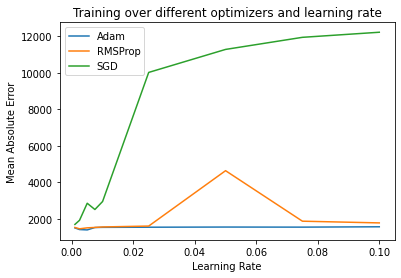

In [75]:
plt.plot(result_report['Learning Rate'], result_report['Adam-Avg'], label='Adam')
plt.plot(result_report['Learning Rate'], result_report['RMSprop-Avg'], label='RMSProp')
plt.plot(result_report['Learning Rate'], result_report['SGD-Avg'], label='SGD')

plt.title('Training over different optimizers and learning rate')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Absolute Error')
plt.legend();

Small learning rate gives better result.

Best parameter -> Adam optimizer with learning rate 0.025

### Regularization & Drop Out

<b>Regularizers</b> allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes.

<b>Dropout</b> is one of the most effective and most commonly used regularization techniques for neural networks. The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

We can combined both of them to avoid overfitting.


In [0]:
regularizer_rates = [0, .001, .01, .1]
dropout_rates = [0, .2, .35, .5]

In [59]:
drp_log, reg_log, mae_log ,mse_log = [], [], [], []

start_computer = time.time()

for i, (train_features, train_target, 
        validation_features, validation_target) in enumerate(train_val_split):
  
    for dropout_rate in dropout_rates:
        print('dropout_rate: {:.2f}'.format(dropout_rate))
        for regularizer_rate in regularizer_rates:
            print('     regularizer_rate: {:.2f}'.format(regularizer_rate))
            mlp = multilayer_perceptron(train_features.shape[1], .025, 'adam', regularizer_rate, dropout_rate)
            model, history = train_model(mlp, train_features, train_target, N_epoch)
            loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=1)
            drp_log.append(dropout_rate)
            reg_log.append(regularizer_rate)
            mae_log.append(mae)
            mse_log.append(mse)
        print("")

    print('    Done for group-{:d}'.format(i+1))

print("Approximation computational time: {:.2f}".format(time.time() - start_compute))

dropout_rate: 0.00
     regularizer_rate: 0.00
9/9 [==============================] - 0s 1ms/step - loss: 1608.7225 - mae: 1540.7009 - mse: 22746176.0000
     regularizer_rate: 0.00
9/9 [==============================] - 0s 2ms/step - loss: 1738.1899 - mae: 1611.8995 - mse: 23337626.0000
     regularizer_rate: 0.01
9/9 [==============================] - 0s 2ms/step - loss: 1747.7653 - mae: 1577.7346 - mse: 22460522.0000
     regularizer_rate: 0.10
9/9 [==============================] - 0s 1ms/step - loss: 2215.5720 - mae: 1875.9808 - mse: 23631974.0000

dropout_rate: 0.20
     regularizer_rate: 0.00
9/9 [==============================] - 0s 2ms/step - loss: 2420.4724 - mae: 2094.0867 - mse: 26347418.0000
     regularizer_rate: 0.00
9/9 [==============================] - 0s 2ms/step - loss: 2574.1101 - mae: 2221.9492 - mse: 26877870.0000
     regularizer_rate: 0.01
9/9 [==============================] - 0s 1ms/step - loss: 2521.7222 - mae: 2154.9468 - mse: 26221076.0000
     regularizer

In [60]:
grp_2d = [["Group-{:d}".format(i+1)]*16 for i in range(n_splits_target)]
grp = [g for grp1 in grp_2d for g in grp1]
len(grp)

64

In [61]:
drp_reg_result = pd.DataFrame({"Group": grp, "Drop-out rate": drp_log, "Regularizer rate": reg_log,
                               "Mean Absolute Error": mae_log, "Mean Squared Error": mse_log})
drp_reg_result

,Group,Drop-out rate,Regularizer rate,Mean Absolute Error,Mean Squared Error
0,Group-1,0.00,0.000,1540.700928,22746176.0
1,Group-1,0.00,0.001,1611.899536,23337626.0
2,Group-1,0.00,0.010,1577.734619,22460522.0
3,Group-1,0.00,0.100,1875.980835,23631974.0
4,Group-1,0.20,0.000,2094.086670,26347418.0
...,...,...,...,...,...
59,Group-4,0.35,0.100,2090.271484,22018862.0
60,Group-4,0.50,0.000,2082.518066,21595176.0
61,Group-4,0.50,0.001,1925.276978,20939406.0
62,Group-4,0.50,0.010,2230.426758,22346018.0


In [62]:
drp_reg_result.to_excel('hyper tuning parameter regularization and drop-out.xlsx', index=False)
print('Saved process done.')

Saved process done.


In [63]:
grp_result = drp_reg_result.groupby(['Drop-out rate', 'Regularizer rate'])[['Mean Absolute Error', 'Mean Squared Error']].mean()
grp_result

Mean Absolute Error  Mean Squared Error
Drop-out rate Regularizer rate                                         
0.00          0.000                     1517.268677         20745776.50
              0.001                     1446.084137         20589117.00
              0.010                     1493.656647         20706491.75
              0.100                     1684.681396         20982337.50
0.20          0.000                     2048.239105         23723344.00
              0.001                     2054.102478         23111842.50
              0.010                     2023.015320         23084158.50
              0.100                     2111.578705         24689851.50
0.35          0.000                     2164.916321         24617566.00
              0.001                     2135.159363         24454174.50
              0.010                     2149.632721         23918260.00
              0.100                     2264.205566         23961310.00
0.50          0.000                     2168.048340         24141316.00
              0.001                     2164.867401         24446141.00
              0.010                     2366.301636         24893305.50
              0.100                     2312.982300         24630832.50

Refer to previous experiment, the better result comes with drop-out rate = 0 and regularizer rate = 0.01 (mae), 0.1 (mse)

### Evaluate with test set

After work on hyper tuning parameter, we can apply the best parameter to test set. And see whether a overfitting issue or not

In [64]:
mae_log ,mse_log = [], []

for train_features, train_target, validation_features, validation_target in train_val_split:

    mlp = multilayer_perceptron(train_features.shape[1], .025, 'adam', 0.01, 0)
    model, history = train_model(mlp, train_features, train_target, N_epoch)
    loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=1)
    mae_log.append(mae)
    mse_log.append(mse)

9/9 [==============================] - 0s 2ms/step - loss: 1387.6746 - mae: 1290.4468 - mse: 17100272.0000


In [65]:
grp_log = ['Group-'+str(i+1) for i in range(n_splits_target)]
log = pd.DataFrame({"Group": grp_log, "Mean Absolute Error": mae_log, "Mean Squared Error": mse_log})
print('Test result with validation set that obtained from train-validation-test split using Sorted Stratified K Fold Cross Validation')
log

Test result with validation set that obtained from train-validation-test split using Sorted Stratified K Fold Cross Validation


,Group,Mean Absolute Error,Mean Squared Error
0,Group-1,1624.671021,22707780.0
1,Group-2,1546.189575,22180042.0
2,Group-3,1553.458862,20831430.0
3,Group-4,1290.446777,17100272.0


In [66]:

print("Minimum MAE =  ",log["Mean Absolute Error"].min())
print("Maximum MAE =  ",log["Mean Absolute Error"].max())
print("Average MAE =  ",log["Mean Absolute Error"].mean())

Minimum MAE =   1290.44677734375
Maximum MAE =   1624.6710205078125
Average MAE =   1503.6915588378906


Right now, we know that our model can get result with 'Mean Absolute Error' between 1416,74 and 1540,08. Now lets check with test set. (N_epoch=4000)

> If you run the cell many times you can get different result. But the interval of MAE will not be much different

In [67]:
test_target = target[normed_test_features.index]
loss, mae, mse = model.evaluate(normed_test_features, test_target)

print("MAE for testing set =  {:5.2f} (charges)".format(mae))

9/9 [==============================] - 0s 2ms/step - loss: 1989.4995 - mae: 1651.0294 - mse: 24732178.0000
MAE for testing set =  1651.03 (charges)


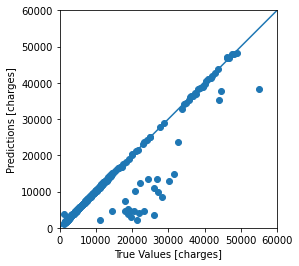

In [68]:
test_predictions = model.predict(normed_test_features).flatten()

a = plt.axes(aspect='equal')

plt.scatter(test_target, test_predictions)

plt.xlabel('True Values [charges]')
plt.ylabel('Predictions [charges]')
lims = [0, 6e4]
plt.xlim(lims)
plt.ylim(lims)

_ = plt.plot(lims, lims)

For this testing we get MAE of 1639,38.


If we compare with result that we obtained from validation set, our model can predict data with MAE 1487,84. We get <b>difference of 151,54 from model validation</b>. That is good result <b>(not overfitting)</b>.

# Results and Conclusion

In [0]:
dataset['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

We have performed regression analysis model to predict health insurance cost should be paid for given features. We have shown in the above, several results related to our MAE for test data. We think from the range of `charges` category in the datasets, our predicted health insurance won't sufficiently good for person who has medical bill around 1000.

As we plot the joint distribution, we can see at glance that there are so much irregularity to the data. If we look closely to some elements in that joint distrbution, there are some clusters related to BMI and charges. It can be inferred another model like clustering can make a group for a range of health insurance bill. This will be another project.

